In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('data/df_detect_peptide_train.csv')
test = pd.read_csv('data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

In [4]:
train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


In [5]:
def get_data_labelEnc(df):
    label_enc = {v:k+1 for k, v in enumerate('ARNDCQEGHILKMFPSTWYV')}
    label_enc['Z']=0
    aa_data = [np.array([seq.count(a) for a in 'ARNDCQEGHILKMFPSTWYV'] + list(np.array([aa2val[aa] for aa in seq]).sum(axis=0)))
               for seq in df.PEP.values]
    pep_data = [[label_enc[aa] for aa in seq] + [0]*(30-len(seq))
               for seq in df.PEP.values]
    en_data = [[label_enc[aa] for aa in seq]
               for seq in df.En.values]
    ec_data = [[label_enc[aa] for aa in seq]
               for seq in df.Ec.values]
    e1_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E1.values]
    e2_data = [[label_enc[aa] for aa in seq]
               if seq != '-' else [0 for _ in range(15)]
               for seq in df.E2.values]
    return np.array(aa_data), np.array(pep_data), np.array(en_data), np.array(ec_data), np.array(e1_data), np.array(e2_data), np.array(df.ID.values)

In [6]:
aa_train, pep_train, en_train, ec_train, e1_train, e2_train, y_train = get_data_labelEnc(train)
aa_val, pep_val, en_val, ec_val, e1_val, e2_val, y_val = get_data_labelEnc(val)
aa_test, pep_test, en_test, ec_test, e1_test, e2_test, y_test = get_data_labelEnc(test)
print(aa_train.shape, pep_train.shape, en_train.shape, ec_train.shape, e1_train.shape, e2_train.shape, y_train.shape)
print(aa_val.shape, pep_val.shape, en_val.shape, ec_val.shape, e1_val.shape, e2_val.shape, y_val.shape)
print(aa_test.shape, pep_test.shape, en_test.shape, ec_test.shape, e1_test.shape, e2_test.shape, y_test.shape)

(543516, 39) (543516, 30) (543516, 15) (543516, 15) (543516, 15) (543516, 15) (543516,)
(135880, 39) (135880, 30) (135880, 15) (135880, 15) (135880, 15) (135880, 15) (135880,)
(133992, 39) (133992, 30) (133992, 15) (133992, 15) (133992, 15) (133992, 15) (133992,)


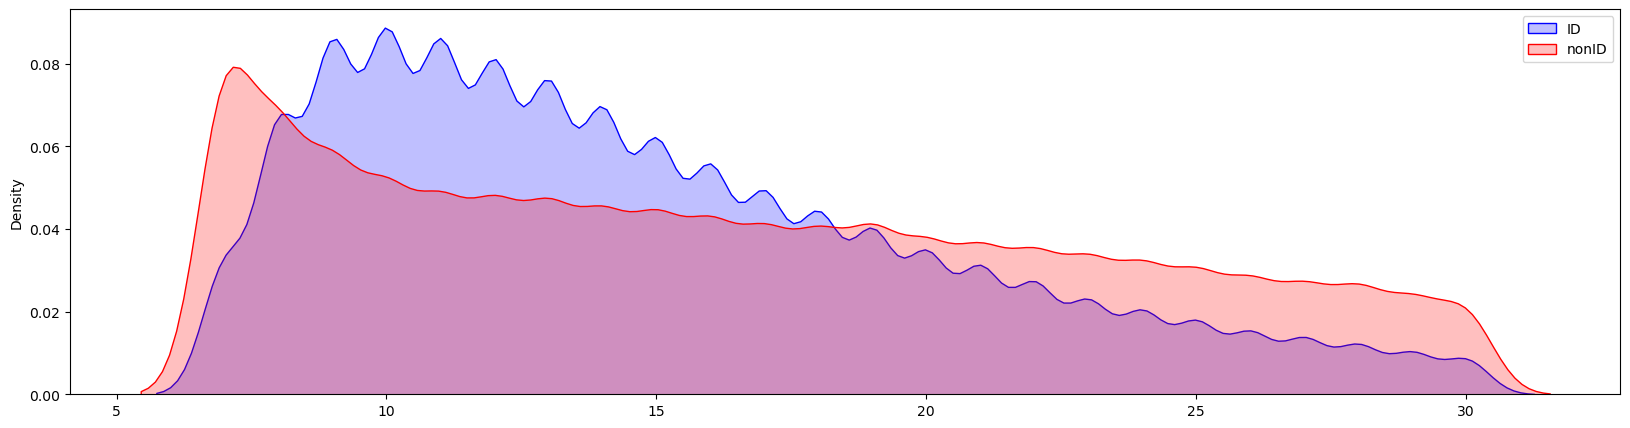

In [7]:
viz = pd.concat([train, val, test], axis=0).reset_index(drop=True)
p = viz.loc[viz.ID==1]
n = viz.loc[viz.ID==0]
pl = p.PEP.apply(lambda x: len(x)).values
nl = n.PEP.apply(lambda x: len(x)).values
plt.figure(figsize=(20,5))
sns.kdeplot(pl, shade=True, color='blue')
sns.kdeplot(nl, shade=True, color='red')
plt.legend(['ID', 'nonID'])
plt.show()

# Train

In [8]:
from tensorflow.python.client import device_lib

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

In [9]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# high param

In [10]:
from tensorflow import keras

In [17]:
# Embedding
pep = tf.keras.layers.Input(shape=((30,)))
pep_embed = tf.keras.layers.Embedding(21, 128, input_length=30, mask_zero=True)(pep)
pep_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_embed)

meta = tf.keras.layers.Input(shape=((39,)))  # peptide info

n = tf.keras.layers.Input(shape=((15,)))
n_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(n)
n_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_embed)

c = tf.keras.layers.Input(shape=((15,)))
c_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(c)
c_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_embed)

m1 = tf.keras.layers.Input(shape=((15,)))
m1_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m1)
m1_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_embed)

m2 = tf.keras.layers.Input(shape=((15,)))
m2_embed = tf.keras.layers.Embedding(21, 32, input_length=15, mask_zero=True)(m2)
m2_embed = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_embed)


# LSTM
net_meta = tf.keras.layers.Dense(32, activation='relu')(meta)
net_meta = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_meta)

n_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(n_embed)
n_lstm = tf.keras.layers.Dense(32, activation='relu')(n_lstm)
n_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(n_lstm)

c_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(c_embed)
c_lstm = tf.keras.layers.Dense(32, activation='relu')(c_lstm)
c_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(c_lstm)

m1_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(m1_embed)
m1_lstm = tf.keras.layers.Dense(32, activation='relu')(m1_lstm)
m1_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m1_lstm)

m2_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(m2_embed)
m2_lstm = tf.keras.layers.Dense(32, activation='relu')(m2_lstm)
m2_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(m2_lstm)

pep_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(145))(pep_embed)
pep_lstm = tf.keras.layers.Dense(128, activation='relu')(pep_lstm)
pep_lstm = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(pep_lstm)


# Dense
merge = tf.keras.layers.concatenate([pep_lstm, 
                                     net_meta,
                                     n_lstm,
                                     c_lstm,
                                     m1_lstm,
                                     m2_lstm])
net_merge = tf.keras.layers.Dense(128, activation='relu')(merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)
net_merge = tf.keras.layers.Dense(64, activation='relu')(net_merge)
net_merge = tf.keras.layers.Dropout(np.random.uniform(0, 0.2))(net_merge)

output = tf.keras.layers.Dense(1, activation = 'sigmoid')(net_merge)

model_high = tf.keras.Model(inputs=[pep, meta, n, c, m1, m2],
                            outputs=[output])

model_high.summary()

model_high.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min', 
                                      verbose=1,
                                      patience=50)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 30)]         0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_29 (InputLayer)           [(None, 15)]         0                                            
____________________________________________________________________________________________

In [19]:
history = model_high.fit([pep_train, aa_train, en_train, ec_train, e1_train, e2_train],
                    y_train, 
                    epochs=100,
                    batch_size=256,
                    validation_data=([pep_val, aa_val, en_val, ec_val, e1_val, e2_val], y_val),
                    callbacks=[es]
                        )

Epoch 1/100
2124/2124 [==============================] - 290s 129ms/step - loss: 1.1045 - accuracy: 0.6750 - val_loss: 0.4948 - val_accuracy: 0.7634
Epoch 2/100
2124/2124 [==============================] - 259s 122ms/step - loss: 0.5103 - accuracy: 0.7574 - val_loss: 0.4777 - val_accuracy: 0.7715
Epoch 3/100
2124/2124 [==============================] - 263s 124ms/step - loss: 0.4850 - accuracy: 0.7718 - val_loss: 0.4598 - val_accuracy: 0.7840
Epoch 4/100
2124/2124 [==============================] - 264s 124ms/step - loss: 0.4656 - accuracy: 0.7838 - val_loss: 0.4495 - val_accuracy: 0.7883
Epoch 5/100
2124/2124 [==============================] - 261s 123ms/step - loss: 0.4534 - accuracy: 0.7916 - val_loss: 0.4345 - val_accuracy: 0.7992
Epoch 6/100
2124/2124 [==============================] - 261s 123ms/step - loss: 0.4412 - accuracy: 0.7980 - val_loss: 0.4267 - val_accuracy: 0.8040
Epoch 7/100
2124/2124 [==============================] - 253s 119ms/step - loss: 0.4330 - accuracy: 0.8029

Epoch 56/100
2124/2124 [==============================] - 328s 154ms/step - loss: 0.3659 - accuracy: 0.8373 - val_loss: 0.3761 - val_accuracy: 0.8331
Epoch 57/100
2124/2124 [==============================] - 320s 151ms/step - loss: 0.3653 - accuracy: 0.8379 - val_loss: 0.3761 - val_accuracy: 0.8326
Epoch 58/100
2124/2124 [==============================] - 327s 154ms/step - loss: 0.3643 - accuracy: 0.8383 - val_loss: 0.3746 - val_accuracy: 0.8346
Epoch 59/100
2124/2124 [==============================] - 330s 155ms/step - loss: 0.3639 - accuracy: 0.8386 - val_loss: 0.3735 - val_accuracy: 0.8351
Epoch 60/100
2124/2124 [==============================] - 325s 153ms/step - loss: 0.3626 - accuracy: 0.8393 - val_loss: 0.3741 - val_accuracy: 0.8338
Epoch 61/100
2124/2124 [==============================] - 324s 152ms/step - loss: 0.3616 - accuracy: 0.8400 - val_loss: 0.3740 - val_accuracy: 0.8338
Epoch 62/100
2124/2124 [==============================] - 327s 154ms/step - loss: 0.3611 - accuracy:

In [20]:
plt.figure(figsize=(16,2))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

# eval

4188/4188 [==============================] - 270s 64ms/step - loss: 0.3822 - accuracy: 0.8301
Test Loss: 0.38222941756248474
Test Accuracy: 0.8301241993904114
              precision    recall  f1-score   support

           0       0.88      0.77      0.82     66996
           1       0.79      0.89      0.84     66996

    accuracy                           0.83    133992
   macro avg       0.84      0.83      0.83    133992
weighted avg       0.84      0.83      0.83    133992

rf auc : 0.914653191908312


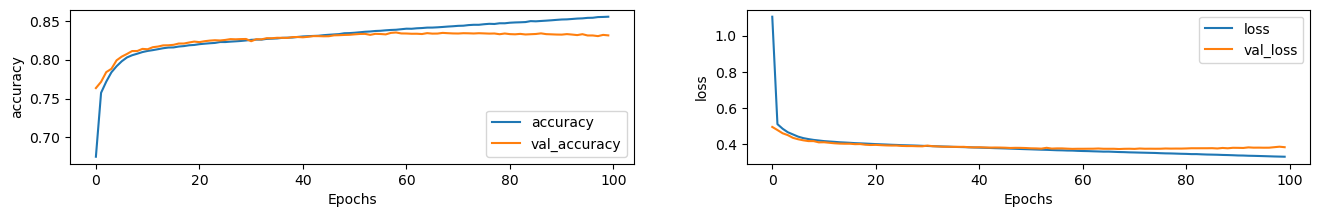

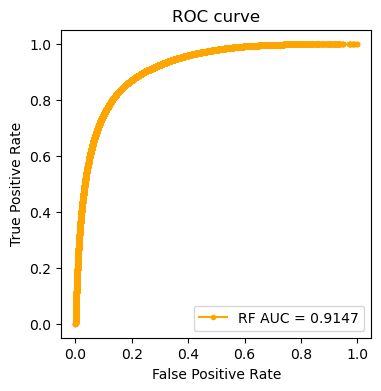

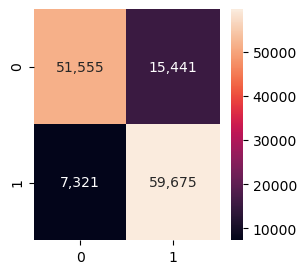

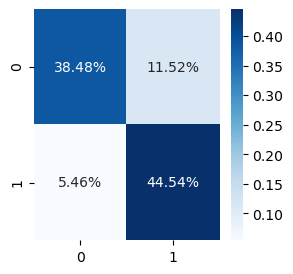

In [21]:
test_loss, test_acc = model_high.evaluate([pep_test, aa_test, en_test, ec_test, e1_test, e2_test], y_test)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

# prediction
y_pred = [1 if i>=0.5 else 0 for i in model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])]
print(classification_report(y_test, y_pred))
# AUC
probs = model_high.predict([pep_test, aa_test, en_test, ec_test, e1_test, e2_test])
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()